In [1]:
from pyspark.sql import functions as F
from pyspark.sql.functions import count, countDistinct, window
from pyspark.sql.functions import explode
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TrendingTopicsAnalyzer").getOrCreate()
    
json_file_path = 'meetups.json' 
raw_data = spark.read.option("mode", "DROPMALFORMED").json("meetups.json")

In [3]:
raw_data.describe().show()

+-------+-------------------+--------------------+--------+--------------------+----------+
|summary|             guests|               mtime|response|             rsvp_id|visibility|
+-------+-------------------+--------------------+--------+--------------------+----------+
|  count|               1541|                1541|    1541|                1541|      1541|
|   mean|0.09669046073977937|1.489917271091866...|    null|1.6584449021161582E9|      null|
| stddev| 0.5275483121532059|1.4369827182243446E8|    null|    2366166.37002244|      null|
|    min|                  0|       1486669182000|      no|          1591862143|    public|
|    max|                 10|       1489926608318|     yes|          1658878916|    public|
+-------+-------------------+--------------------+--------+--------------------+----------+



In [4]:
raw_data.printSchema()

root
 |-- event: struct (nullable = true)
 |    |-- event_id: string (nullable = true)
 |    |-- event_name: string (nullable = true)
 |    |-- event_url: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- group: struct (nullable = true)
 |    |-- group_city: string (nullable = true)
 |    |-- group_country: string (nullable = true)
 |    |-- group_id: long (nullable = true)
 |    |-- group_lat: double (nullable = true)
 |    |-- group_lon: double (nullable = true)
 |    |-- group_name: string (nullable = true)
 |    |-- group_state: string (nullable = true)
 |    |-- group_topics: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- topic_name: string (nullable = true)
 |    |    |    |-- urlkey: string (nullable = true)
 |    |-- group_urlname: string (nullable = true)
 |-- guests: long (nullable = true)
 |-- member: struct (nullable = true)
 |    |-- member_id: long (nullable = true)
 |    |-- member_name: string (nullabl

In [5]:
# Count the number of occurrences of each response
response_counts = raw_data.groupBy("response").count()

# Show the counts
response_counts.show()

+--------+-----+
|response|count|
+--------+-----+
|      no|  414|
|     yes| 1127|
+--------+-----+



In [6]:
parsed_data = raw_data.filter(raw_data.response == 'yes').select("group.group_topics.topic_name", "mtime", "group.group_city", "group.group_country", "group.group_id", "event.event_id", "event.event_name")

In [72]:
raw_data.to

+--------------------+--------------------+------+--------------------+-------------+--------+----------+--------------------+----------+
|               event|               group|guests|              member|        mtime|response|   rsvp_id|               venue|visibility|
+--------------------+--------------------+------+--------------------+-------------+--------+----------+--------------------+----------+
|{jkpwmlywgbmb, Pl...|{Taipei, tw, 1658...|     0|{120119272, Allen...|1489925470960|      no|1658733801|{0.0, 0.0, 237797...|    public|
|{hvkmsmywfbhc, Ne...|{Taipei, tw, 1874...|     0|{221379606, Benit...|1489925471668|      no|1658877353|{25.052959, 121.5...|    public|
|{236222256, Meet ...|{Hackensack, us, ...|     0|{44748032, Valeri...|1489925472035|     yes|1658877355|{0.0, 0.0, 249450...|    public|
|{zblmsmywfbzb, Po...|{London, gb, 2015...|     0|{198145818, zhuch...|1489925473108|      no|1658519661|{51.564991, -0.18...|    public|
|{trgqlmywfbzb, Fr...|{London, gb,

In [7]:
parsed_data.printSchema()

root
 |-- topic_name: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- mtime: long (nullable = true)
 |-- group_city: string (nullable = true)
 |-- group_country: string (nullable = true)
 |-- group_id: long (nullable = true)
 |-- event_id: string (nullable = true)
 |-- event_name: string (nullable = true)



In [8]:
parsed_data.show(5)

+--------------------+-------------+----------+-------------+--------+------------+--------------------+
|          topic_name|        mtime|group_city|group_country|group_id|    event_id|          event_name|
+--------------------+-------------+----------+-------------+--------+------------+--------------------+
|[Wine, Hiking, Di...|1489925472035|Hackensack|           us|17370312|   236222256|Meet & Greet Iceb...|
|[French Language ...|1489925473189|    London|           gb|20006170|trgqlmywfbzb|French Language &...|
|[BBQ, English as ...|1489925474149|     Tokyo|           jp|18663131|   238532428|Fun Cooking and C...|
|[orchestra, Flute...|1489925475416|    London|           gb|20325660|   238532429|The Wish List (So...|
|[Wine, Hiking, Di...|1489925472000|Hackensack|           us|17370312|   236222256|Meet & Greet Iceb...|
+--------------------+-------------+----------+-------------+--------+------------+--------------------+
only showing top 5 rows



In [9]:
# Count the total number of event_id entries
total_count = parsed_data.select(count("event_id")).first()[0]

# Count the number of distinct event_id entries
distinct_count = parsed_data.select(countDistinct("event_id")).first()[0]

In [10]:
total_count, distinct_count

(1127, 827)

In [11]:
# Count the number of occurrences of each row
counts = parsed_data.groupBy(parsed_data.columns).count()

# Keep only the rows that occur more than once
duplicates = counts.filter(counts['count'] > 1)

# Show the duplicates
duplicates.show(5)

+--------------------+-------------+-------------+-------------+--------+------------+--------------------+-----+
|          topic_name|        mtime|   group_city|group_country|group_id|    event_id|          event_name|count|
+--------------------+-------------+-------------+-------------+--------+------------+--------------------+-----+
|[A Cappella, Musi...|1489926483000|Saint Charles|           us|13907892|dffhmlywfbcc|Sing a cappella h...|    3|
|[New In Town, Ita...|1489925674000|    Barcelona|           es|18453452|ppghmmywfbbc|Handmade PASTA-LA...|    2|
|[Toastmasters, Pu...|1489590754000|  Stittsville|           ca|20120973|wqjqvlywfbdc|Lets get together...|    3|
|[Dining Out, Nigh...|1489926316000|      Buffalo|           us|20072809|sbxssmywfbmc|Hit some balls to...|    2|
+--------------------+-------------+-------------+-------------+--------+------------+--------------------+-----+



In [12]:
# Convert the 'mtime' field to a date
parsed_data = parsed_data.withColumn('timestamp', F.from_unixtime(col('mtime') / 1000).cast('timestamp'))

# Show the DataFrame
parsed_data.show(5)

+--------------------+-------------+----------+-------------+--------+------------+--------------------+-------------------+
|          topic_name|        mtime|group_city|group_country|group_id|    event_id|          event_name|          timestamp|
+--------------------+-------------+----------+-------------+--------+------------+--------------------+-------------------+
|[Wine, Hiking, Di...|1489925472035|Hackensack|           us|17370312|   236222256|Meet & Greet Iceb...|2017-03-19 13:11:12|
|[French Language ...|1489925473189|    London|           gb|20006170|trgqlmywfbzb|French Language &...|2017-03-19 13:11:13|
|[BBQ, English as ...|1489925474149|     Tokyo|           jp|18663131|   238532428|Fun Cooking and C...|2017-03-19 13:11:14|
|[orchestra, Flute...|1489925475416|    London|           gb|20325660|   238532429|The Wish List (So...|2017-03-19 13:11:15|
|[Wine, Hiking, Di...|1489925472000|Hackensack|           us|17370312|   236222256|Meet & Greet Iceb...|2017-03-19 13:11:12|


In [13]:
# Group by event_id and count the number of rows
event_counts = parsed_data.groupBy("event_id").count()

# Order by count in descending order and get the first row
top_event = event_counts.orderBy(F.desc("count")).first()

# Print the event_id with the most rows
print(f"The event_id with the most rows is: {top_event['event_id']}")

The event_id with the most rows is: 238532425


In [14]:
filtered_data = parsed_data.filter(parsed_data.event_id == '238532425')

# Show the filtered DataFrame
filtered_data.show()

+--------------------+-------------+----------+-------------+--------+---------+--------------------+-------------------+
|          topic_name|        mtime|group_city|group_country|group_id| event_id|          event_name|          timestamp|
+--------------------+-------------+----------+-------------+--------+---------+--------------------+-------------------+
|[Software Develop...|1489925525826| Liverpool|           gb|19799021|238532425|promoting local t...|2017-03-19 13:12:05|
|[Software Develop...|1489925568005| Liverpool|           gb|19799021|238532425|promoting local t...|2017-03-19 13:12:48|
|[Software Develop...|1489925568000| Liverpool|           gb|19799021|238532425|promoting local t...|2017-03-19 13:12:48|
|[Software Develop...|1489925744222| Liverpool|           gb|19799021|238532425|promoting local t...|2017-03-19 13:15:44|
|[Software Develop...|1489925887756| Liverpool|           gb|19799021|238532425|promoting local t...|2017-03-19 13:18:07|
|[Software Develop...|14

In [15]:
# Create a new DataFrame with "topic" and "event_name" columns
exploded_topics = parsed_data.select(explode(parsed_data.topic_name).alias("topic"), "event_name", "event_id")

In [16]:
exploded_topics.count()

12597

In [17]:
# Remove duplicates
exploded_topics = exploded_topics.dropDuplicates(["topic", "event_name", "event_id"])

In [18]:
exploded_topics.count()

9319

In [19]:
# Show the DataFrame
exploded_topics.show(15)

+--------------------+--------------------+------------+
|               topic|          event_name|    event_id|
+--------------------+--------------------+------------+
| Product Development|       Hack 'n' Talk|tlnqtlywgbhb|
|  Role-Playing Games|Wednesday Board G...|rskwtlywfbdc|
|      Data Analytics|Forecasting Ebola...|   238449814|
|    Online Marketing|Lancer un busines...|   238384040|
|      British Movies|Lunch at Sabai Sa...|   238528934|
|        Conversation|לנקות את הצלחת - ...|   238532456|
|Microsoft Windows...|Akademia C# Spotk...|   238532008|
|          Percussion|How Sweet It Is -...|   238532473|
|       Female Bikers|Dinner Meet & Gre...|   238508979|
|Sports and Recrea...|    BOARD GAME NIGHT|   238488378|
|         Songwriting|meet up and discu...|sxxzhlywfbgc|
|   Social Networking|Fun Cooking and C...|   238532494|
|   Social Networking|Bollywood night!!...|   238341314|
|          Dining Out|  Vegan Street Faire|   238224352|
|       Racket Sports|Tuesday I

In [20]:
exploded_topics.count()

9319

In [21]:
# Tokenize the event_name and topic columns
event_tokenizer = Tokenizer(inputCol="event_name", outputCol="event_words")
topic_tokenizer = Tokenizer(inputCol="topic", outputCol="topic_words")

wordsData = event_tokenizer.transform(exploded_topics)
wordsData = topic_tokenizer.transform(wordsData)

In [22]:
wordsData.count()

9319

In [23]:
wordsData.show()

+--------------------+--------------------+------------+--------------------+--------------------+
|               topic|          event_name|    event_id|         event_words|         topic_words|
+--------------------+--------------------+------------+--------------------+--------------------+
| Product Development|       Hack 'n' Talk|tlnqtlywgbhb|   [hack, 'n', talk]|[product, develop...|
|  Role-Playing Games|Wednesday Board G...|rskwtlywfbdc|[wednesday, board...|[role-playing, ga...|
|      Data Analytics|Forecasting Ebola...|   238449814|[forecasting, ebo...|   [data, analytics]|
|    Online Marketing|Lancer un busines...|   238384040|[lancer, un, busi...| [online, marketing]|
|      British Movies|Lunch at Sabai Sa...|   238528934|[lunch, at, sabai...|   [british, movies]|
|        Conversation|לנקות את הצלחת - ...|   238532456|[לנקות, את, הצלחת...|      [conversation]|
|Microsoft Windows...|Akademia C# Spotk...|   238532008|[akademia, c#, sp...|[microsoft, windo...|
|         

In [24]:
# Hash the words to a fixed length feature vector
event_hashingTF = HashingTF(inputCol="event_words", outputCol="event_rawFeatures")
topic_hashingTF = HashingTF(inputCol="topic_words", outputCol="topic_rawFeatures")

featurizedData = event_hashingTF.transform(wordsData)
featurizedData = topic_hashingTF.transform(featurizedData)

# Rescale the feature vectors
event_idf = IDF(inputCol="event_rawFeatures", outputCol="event_features")
topic_idf = IDF(inputCol="topic_rawFeatures", outputCol="topic_features")

event_idfModel = event_idf.fit(featurizedData)
rescaledData = event_idfModel.transform(featurizedData)

topic_idfModel = topic_idf.fit(rescaledData)
rescaledData = topic_idfModel.transform(rescaledData)

In [25]:
rescaledData.count()

9319

In [26]:
rescaledData.show()

+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               topic|          event_name|    event_id|         event_words|         topic_words|   event_rawFeatures|   topic_rawFeatures|      event_features|      topic_features|
+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Product Development|       Hack 'n' Talk|tlnqtlywgbhb|   [hack, 'n', talk]|[product, develop...|(262144,[17587,70...|(262144,[52879,19...|(262144,[17587,70...|(262144,[52879,19...|
|  Role-Playing Games|Wednesday Board G...|rskwtlywfbdc|[wednesday, board...|[role-playing, ga...|(262144,[169300,1...|(262144,[104739,1...|(262144,[169300,1...|(262144,[104739,1...|
|      Data Analytics|Forecasting Ebola...|   238449814|[forecasting, ebo...|   [data

In [27]:
# Define a UDF to compute cosine similarity
def cosine_similarity(a, b):
    return float(a.dot(b) / (a.norm(2) * b.norm(2)))

cosine_similarity_udf = F.udf(cosine_similarity, FloatType())

# Compute cosine similarity between event_name and topic vectors
result = rescaledData.withColumn("similarity", cosine_similarity_udf(col("event_features"), col("topic_features")))

# Show the DataFrame
result.select("event_name", "topic", "similarity").show()

+--------------------+--------------------+----------+
|          event_name|               topic|similarity|
+--------------------+--------------------+----------+
|       Hack 'n' Talk| Product Development|       0.0|
|Wednesday Board G...|  Role-Playing Games|0.23263572|
|Forecasting Ebola...|      Data Analytics|       0.0|
|Lancer un busines...|    Online Marketing|       0.0|
|Lunch at Sabai Sa...|      British Movies|       0.0|
|לנקות את הצלחת - ...|        Conversation|       0.0|
|Akademia C# Spotk...|Microsoft Windows...|       0.0|
|How Sweet It Is -...|          Percussion|       0.0|
|Dinner Meet & Gre...|       Female Bikers|       0.0|
|    BOARD GAME NIGHT|Sports and Recrea...|       0.0|
|meet up and discu...|         Songwriting|       0.0|
|Fun Cooking and C...|   Social Networking|       0.0|
|Bollywood night!!...|   Social Networking|       0.0|
|  Vegan Street Faire|          Dining Out|       0.0|
|Tuesday Intermedi...|       Racket Sports|       0.0|
|Rockville

i see poor result of algoritm. for example I see topic " Data Analytics" and the word in event_name "Forecasting" and similarity is 0.0. It's wrong. 
I think that the problem is in the algorithm. I need to use another algorithm.

In [28]:
result.columns

['topic',
 'event_name',
 'event_id',
 'event_words',
 'topic_words',
 'event_rawFeatures',
 'topic_rawFeatures',
 'event_features',
 'topic_features',
 'similarity']

In [29]:
# Remove redundant columns
result = result.drop('event_words',
'event_name',                     
 'topic_words',
 'event_rawFeatures',
 'topic_rawFeatures',
 'event_features',
 'topic_features')

# Remove rows with 0.0 similarity
result = result.filter(result.similarity != 0.0)

In [30]:
result.count()

1004

In [31]:
from pyspark.sql.window import Window
from pyspark.sql.functions import desc, row_number, col

# Define a window partitioned by event_id, ordered by similarity
window = Window.partitionBy("event_id").orderBy(desc("similarity"))

# Add a row_number for each window
result = result.withColumn("rn", row_number().over(window))

# Select the rows where rn is 1 (i.e., the rows with the highest similarity for each event_id)
result = result.where(col("rn") == 1)

# Drop the rn column
result = result.drop("rn")

In [32]:
result.show()

+--------------------+---------+-----------+
|               topic| event_id| similarity|
+--------------------+---------+-----------+
|       Deep Learning|233440488| 0.44796947|
|            Ethereum|234119236| 0.41926128|
|    Books and Drinks|234829379| 0.25476298|
|   Social Networking|235405145| 0.21779336|
|           Book Club|235601721|  0.8386863|
|   Social Networking|235968168| 0.21121848|
|  20's & 30's Social|236090520|0.054174487|
|         New In Town|236222256| 0.10347391|
|     Virtual Reality|236266989| 0.34098482|
|      Women Who Code|236574801| 0.72250307|
|      Pranic Healing|236609658| 0.43017942|
|              Hiking|236745952|  0.3568821|
|   Business Strategy|236784423|  0.1643855|
|        Apache Spark|237045601| 0.40298325|
|             Camping|237138989| 0.47646442|
|             Camping|237151476| 0.38219303|
|             Camping|237151539| 0.38219303|
|             Mapping|237158715|  0.5812929|
|Learn to Ski or S...|237187978|0.077956505|
|    Machi

In [33]:
parsed_data = parsed_data.select(["topic_name", "group_city", "group_country","event_id","timestamp"]).dropDuplicates()

In [34]:
parsed_data.show()

+--------------------+------------+-------------+------------+-------------------+
|          topic_name|  group_city|group_country|    event_id|          timestamp|
+--------------------+------------+-------------+------------+-------------------+
|[Joss Whedon, Buf...|      Boston|           us|   237849018|2017-03-19 13:18:15|
|[Business Strateg...|    New York|           us|sckdnmywfbgc|2017-03-19 13:18:56|
|[Outdoors, Outdoo...|      London|           gb|   238379549|2017-03-19 13:23:35|
|[20's & 30's Soci...|   Charlotte|           us|   237989253|2017-03-19 13:23:51|
|[Makeup, Beauty I...|Falls Church|           us|   238044963|2017-03-19 13:25:39|
|[Open Source, Pyt...|       Delhi|           in|nsnhsmywgbcb|2017-03-19 13:22:43|
|[Network Marketin...|     Hamburg|           de|   238394135|2017-03-19 13:25:48|
|[Fitness, Line Da...|Independence|           us|nqhrslywfbfc|2017-03-19 13:28:50|
|[.NET, C#, Softwa...|      Warsaw|           pl|   238532008|2017-03-19 13:13:02|
|[Ru

In [35]:
matchted_data = parsed_data.join(result, ["event_id"], "inner")

In [36]:
matchted_data.show()

+------------+--------------------+-------------+-------------+-------------------+--------------------+-----------+
|    event_id|          topic_name|   group_city|group_country|          timestamp|               topic| similarity|
+------------+--------------------+-------------+-------------+-------------------+--------------------+-----------+
|   237849018|[Joss Whedon, Buf...|       Boston|           us|2017-03-19 13:18:15|           Book Club|  0.6419117|
|   238379549|[Outdoors, Outdoo...|       London|           gb|2017-03-19 13:23:35|    Outdoor  Fitness| 0.21032564|
|nqhrslywfbfc|[Fitness, Line Da...| Independence|           us|2017-03-19 13:28:50| Learn to Line Dance|   0.474158|
|   238532008|[.NET, C#, Softwa...|       Warsaw|           pl|2017-03-19 13:13:02|                  C#| 0.38563585|
|   238391780|[Joss Whedon, Buf...|       Boston|           us|2017-03-19 13:16:28|              Social|  0.5120712|
|vxtjmmywfbbc|[Yoga, Meditation...|       Lisbon|           pt|2

In [37]:
# Drop rows from parsed_data where event_id is not in result
not_matchted_data = parsed_data.join(result, ["event_id"], "left_anti")

In [38]:
result.count(), matchted_data.count(), parsed_data.count(), not_matchted_data.count()

(388, 463, 1011, 548)

In [39]:
# Tokenize the event_name and topic columns
event_tokenizer = Tokenizer(inputCol="event_name", outputCol="event_words")
topic_tokenizer = Tokenizer(inputCol="topic", outputCol="topic_words")

wordsData = event_tokenizer.transform(exploded_topics)
wordsData = topic_tokenizer.transform(wordsData)

# Train a Word2Vec model
word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="event_words", outputCol="event_features")
model = word2Vec.fit(wordsData)
result = model.transform(wordsData)

word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="topic_words", outputCol="topic_features")
model = word2Vec.fit(result)
result = model.transform(result)

# Define a UDF to compute cosine similarity
def cosine_similarity(a, b):
    return float(a.dot(b) / (a.norm(2) * b.norm(2)))

cosine_similarity_udf = udf(cosine_similarity, FloatType())

# Compute cosine similarity between event_name and topic vectors
result = result.withColumn("similarity", cosine_similarity_udf(col("event_features"), col("topic_features")))

# Show the DataFrame
result.select("event_name", "topic", "similarity").show()

+--------------------+--------------------+------------+
|          event_name|               topic|  similarity|
+--------------------+--------------------+------------+
|       Hack 'n' Talk| Product Development| -0.15382715|
|Wednesday Board G...|  Role-Playing Games|  -0.2427865|
|Forecasting Ebola...|      Data Analytics| -0.07854042|
|Lancer un busines...|    Online Marketing| -0.44964573|
|Lunch at Sabai Sa...|      British Movies| -0.33558342|
|לנקות את הצלחת - ...|        Conversation| -0.29763067|
|Akademia C# Spotk...|Microsoft Windows...|  -0.4534469|
|How Sweet It Is -...|          Percussion|  0.97047687|
|Dinner Meet & Gre...|       Female Bikers|  0.52275676|
|    BOARD GAME NIGHT|Sports and Recrea...|  -0.9237514|
|meet up and discu...|         Songwriting|   0.6696389|
|Fun Cooking and C...|   Social Networking|   0.8867227|
|Bollywood night!!...|   Social Networking|  0.20406201|
|  Vegan Street Faire|          Dining Out| -0.96862286|
|Tuesday Intermedi...|       Ra

In [71]:
result.columns

['topic', 'event_id', 'similarity']

In [40]:
# Define a window partitioned by event_id, ordered by similarity
window = Window.partitionBy("event_id").orderBy(desc("similarity"))

# Add a row_number for each window
result = result.withColumn("rn", row_number().over(window))

# Select the rows where rn is 1 (i.e., the rows with the highest similarity for each event_id)
result = result.where(col("rn") == 1)

# Drop the rn column
result = result.drop("rn")

In [41]:
result.columns

['topic',
 'event_name',
 'event_id',
 'event_words',
 'topic_words',
 'event_features',
 'topic_features',
 'similarity']

In [42]:
# Remove redundant columns
result = result.drop('event_words',
'event_name',                     
 'topic_words',
 'event_features',
 'topic_features')

# Remove rows with 0.0 similarity
result = result.filter(result.similarity != 0.0)

In [43]:
matchted_data = parsed_data.join(result, ["event_id"], "inner")
# Drop rows from parsed_data where event_id is not in result
not_matchted_data = parsed_data.join(result, ["event_id"], "left_anti")

In [44]:
result.count(), matchted_data.count(), parsed_data.count(), not_matchted_data.count()

(827, 1011, 1011, 0)

In [45]:
matchted_data.show()

+---------+--------------------+-------------+-------------+-------------------+--------------------+----------+
| event_id|          topic_name|   group_city|group_country|          timestamp|               topic|similarity|
+---------+--------------------+-------------+-------------+-------------------+--------------------+----------+
|230195190|[Marketing, Small...|        Dubai|           ae|2017-03-19 13:15:32|  Mobile Development| 0.9828593|
|233237425|[Hiking, Photo Wa...|   Wellington|           gb|2017-03-19 13:28:27|              Hiking|0.49070668|
|233440488|[Artificial Intel...|       Warsaw|           pl|2017-03-19 13:14:32|               SciPy|0.58358026|
|233884453|[Hiking, Outdoors...|      Glasgow|           gb|2017-03-19 13:12:06|              Hiking| 0.3832757|
|234119236|[Virtual Currency...|        Lagos|           ng|2017-03-19 13:21:01|        Cryptoequity|0.89038694|
|234631425|[Science, Farmers...|     Brisbane|           au|2017-03-19 13:28:11|          Futuro

In [46]:
# find  min timestamp
min_timestamp = matchted_data.select(F.min("timestamp")).first()[0]

In [47]:
min_timestamp

datetime.datetime(2017, 2, 9, 20, 39, 42)

In [48]:
# find max timestamp
max_timestamp = matchted_data.select(F.max("timestamp")).first()[0]

In [49]:
days = matchted_data.select(F.to_date("timestamp").alias("date")).distinct().orderBy("date")

In [50]:
days.show()

+----------+
|      date|
+----------+
|2017-02-09|
|2017-02-14|
|2017-02-23|
|2017-03-15|
|2017-03-16|
|2017-03-17|
|2017-03-18|
|2017-03-19|
+----------+



In [51]:
unique_days_count = matchted_data.select(F.date_format("timestamp", "yyyy-MM-dd").alias("date")).distinct().withColumn("count", F.lit(0)).orderBy("date")

In [52]:
# calculate for each day count of rows in matchted_data
days_count = matchted_data.select(F.date_format("timestamp", "yyyy-MM-dd").alias("date")).groupBy("date").count().orderBy("date")

In [53]:
days_count.show()

+----------+-----+
|      date|count|
+----------+-----+
|2017-02-09|    1|
|2017-02-14|    2|
|2017-02-23|    1|
|2017-03-15|    1|
|2017-03-16|    1|
|2017-03-17|    2|
|2017-03-18|    2|
|2017-03-19| 1001|
+----------+-----+



In [54]:
from pyspark.sql.functions import date_format

In [55]:
data_plot = matchted_data.filter(date_format(col("timestamp"), "yyyy-MM-dd") == "2017-03-19")

In [56]:
data_plot.show()

+---------+--------------------+-------------+-------------+-------------------+--------------------+----------+
| event_id|          topic_name|   group_city|group_country|          timestamp|               topic|similarity|
+---------+--------------------+-------------+-------------+-------------------+--------------------+----------+
|230195190|[Marketing, Small...|        Dubai|           ae|2017-03-19 13:15:32|  Mobile Development| 0.9828593|
|233237425|[Hiking, Photo Wa...|   Wellington|           gb|2017-03-19 13:28:27|              Hiking|0.49070668|
|233440488|[Artificial Intel...|       Warsaw|           pl|2017-03-19 13:14:32|               SciPy|0.58358026|
|233884453|[Hiking, Outdoors...|      Glasgow|           gb|2017-03-19 13:12:06|              Hiking| 0.3832757|
|234119236|[Virtual Currency...|        Lagos|           ng|2017-03-19 13:21:01|        Cryptoequity|0.89038694|
|234631425|[Science, Farmers...|     Brisbane|           au|2017-03-19 13:28:11|          Futuro

In [57]:
from pyspark.sql.functions import window, col

# Define the window duration and sliding interval
window_duration = "8 hours"  # Change as needed
slide_duration = "2 hours"  # Change as needed

# Group by window and topic, and count occurrences
windowedCounts = data_plot.groupBy(
    window(col("timestamp"), window_duration, slide_duration),
    col("topic")
).count()

In [58]:
windowedCounts.show(5)

+--------------------+--------------------+-----+
|              window|               topic|count|
+--------------------+--------------------+-----+
|{2017-03-19 11:00...|   urban agriculture|    1|
|{2017-03-19 09:00...|South Asian Desi ...|    1|
|{2017-03-19 09:00...|             Dancing|    5|
|{2017-03-19 09:00...|       Amazon Seller|    1|
|{2017-03-19 11:00...|       Female Bikers|    1|
+--------------------+--------------------+-----+
only showing top 5 rows



In [59]:
from pyspark.sql import Window

In [60]:
from pyspark.sql.functions import window, col, desc, rank

In [61]:
N = 5

In [62]:
# Rank topics within each window
windowSpec = Window.partitionBy("window").orderBy(desc("count"))
allRank = windowedCounts.withColumn("rank", rank().over(windowSpec))

topN = allRank.filter(col("rank") <= N)  # N is your desired top topics

# Collect data for plotting
# result = topN.collect()

In [63]:
allRank.describe().show()

+-------+-----------------+------------------+------------------+
|summary|            topic|             count|              rank|
+-------+-----------------+------------------+------------------+
|  count|             1693|              1693|              1693|
|   mean|             null|2.3650324867099823|125.92734790313054|
| stddev|             null| 4.272376078266628|57.031357057502916|
|    min|             .NET|                 1|                 1|
|    max|urban agriculture|                52|               170|
+-------+-----------------+------------------+------------------+



In [64]:
topN.describe().show()

+-------+-----------------+-----------------+------------------+
|summary|            topic|            count|              rank|
+-------+-----------------+-----------------+------------------+
|  count|               25|               25|                25|
|   mean|             null|            27.08|               2.6|
| stddev|             null|17.32031562452986|1.5275252316519468|
|    min|   Expat American|                1|                 1|
|    max|Social Networking|               52|                 5|
+-------+-----------------+-----------------+------------------+



In [65]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")


In [66]:
# Convert the Spark DataFrame to a Pandas DataFrame
pd_df = topN.toPandas()

In [67]:
pd_df

,window,topic,count,rank
0,"{'start': 2017-03-18 19:00:00+01:00, 'end': 20...",Linux,1,1
1,"{'start': 2017-03-18 21:00:00+01:00, 'end': 20...",Linux,1,1
2,"{'start': 2017-03-18 23:00:00+01:00, 'end': 20...",Linux,1,1
3,"{'start': 2017-03-19 01:00:00+01:00, 'end': 20...",Linux,1,1
4,"{'start': 2017-03-19 05:00:00+01:00, 'end': 20...",Expat American,1,1
5,"{'start': 2017-03-19 07:00:00+01:00, 'end': 20...",Social Networking,52,1
6,"{'start': 2017-03-19 07:00:00+01:00, 'end': 20...",Social,44,2
7,"{'start': 2017-03-19 07:00:00+01:00, 'end': 20...",Hiking,26,3
8,"{'start': 2017-03-19 07:00:00+01:00, 'end': 20...",Fun Times,25,4
9,"{'start': 2017-03-19 07:00:00+01:00, 'end': 20...",New In Town,21,5


In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract 'start' timestamp from 'window' column
# pd_df['date'] = pd_df['window'].apply(lambda x: x['start'])

# Extract 'start' timestamp from 'window' column and convert to time
pd_df['time'] = pd_df['window'].apply(lambda x: x['start'].strftime('%H:%M'))

# Convert 'date' to datetime
# pd_df['date'] = pd.to_datetime(pd_df['date'])

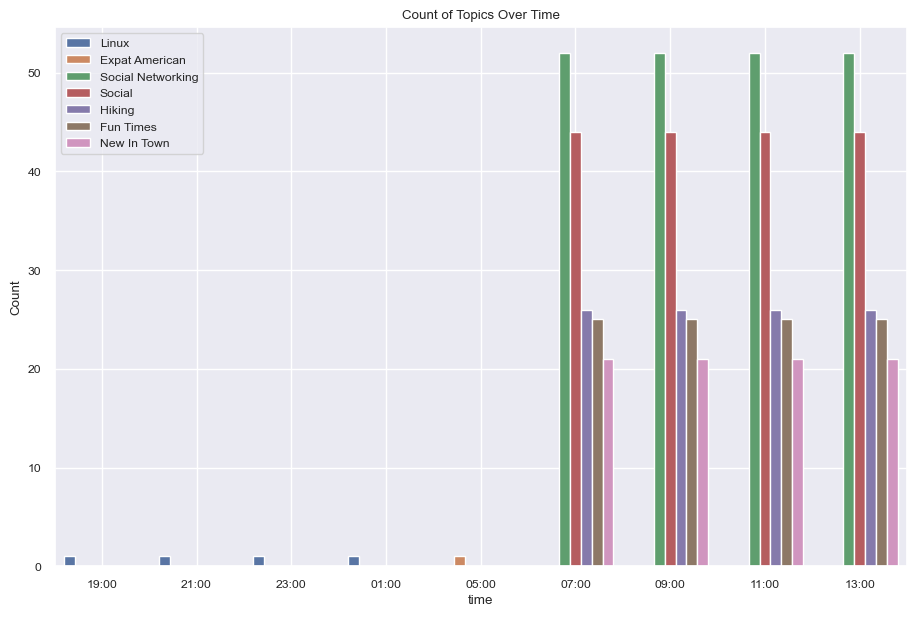

In [69]:
sns.set_style("whitegrid")
plt.figure(figsize=(11,7))
sns.set(font_scale=0.8)
plt.title('Count of Topics Over Time')
p = sns.barplot(x='time', hue="topic", y='count',data=pd_df)
_ = p.set(xlabel="time", ylabel="Count")
plt.legend(loc='upper left')
plt.grid(True) 

In [70]:
 # Stop the Spark Session
# spark.stop()